# Diabetes Prediction | Feature Engineering, EDA, and Modeling

<img src="https://apollosugar.com/wp-content/uploads/2019/03/Diabetes-Blood-Tests.jpg" alt="DBtest">

# About Dataset

**English**

**Business Problem**

It is desired to develop a machine learning model that can predict whether people have diabetes when their characteristics are specified.



**Dataset Story**

The dataset is part of the large dataset held at the National Institutes of Diabetes-Digestive-Kidney Diseases in the USA. Data used for diabetes research on Pima Indian women aged 21 and over living in Phoenix, the 5th largest city in the State of Arizona in the USA. The target variable is specified as "outcome"; 1 indicates positive diabetes test result, 0 indicates negative.

**Columns**

Pregnancies: Number of times pregnant

Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test

BloodPressure: Diastolic blood pressure (mm Hg)

SkinThickness: Triceps skin fold thickness (mm)

Insulin: 2-Hour serum insulin (mu U/ml)

BMI: Body mass index (weight in kg/(height in m)^2)

DiabetesPedigreeFunction: Diabetes pedigree function

Age: Age (years)

Outcome: Class variable (0 or 1)

<hr style="border: 1px solid black; width: 99%; margin-left: 0;">


**Türkçe**

İş Problemi

Özellikleri belirtildiğinde kişilerin diyabet hastası olup olmadıklarını tahmin 
edebilecek bir makine öğrenmesi modeli geliştirilmesi istenmektedir.

Veri Seti Hikayesi


Veri seti ABD'deki Ulusal Diyabet-Sindirim-Böbrek Hastalıkları Enstitüleri'nde tutulan büyük veri setinin parçasıdır. ABD'deki
Arizona Eyaleti'nin en büyük 5. şehri olan Phoenix şehrinde yaşayan 21 yaş ve üzerinde olan Pima Indian kadınları üzerinde
yapılan diyabet araştırması için kullanılan verilerdir.
Hedef değişken "outcome" olarak belirtilmiş olup; 1 diyabet test sonucunun pozitif oluşunu, 0 ise negatif oluşunu belirtmektedir.

**Kolonlar**

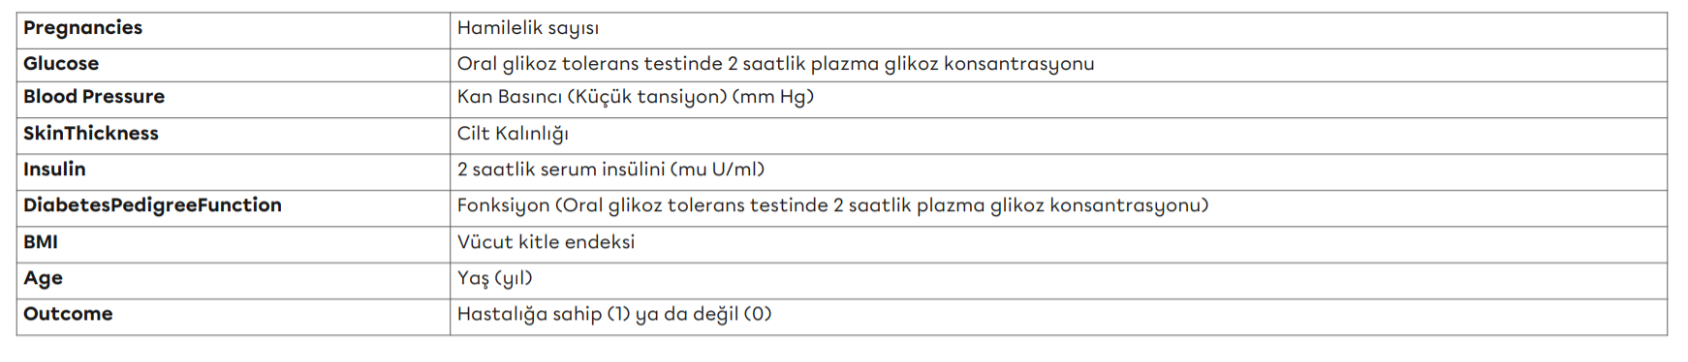

# Packages and reading the dataset

In [77]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
import math
from scipy.stats import norm
from scipy.stats import kruskal
from scipy.stats import kstest
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [78]:
def load_application_train():
    data = pd.read_csv("diabetes.csv")
    return data

df = load_application_train()
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Exploratory Data Analysis

In [79]:
def grab_col_names(dataframe, cat_th=10, car_th=20):  
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
        
    return cat_cols, num_cols, cat_but_car

def cat_summary(dataframe, col_name, plot=False):

    if dataframe[col_name].dtypes == "bool":
        dataframe[col_name] = dataframe[col_name].astype(int)

        print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
        print("##########################################")

        if plot:
            sns.countplot(x=dataframe[col_name], data=dataframe)
            plt.show(block=True)
    else:
        print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
        print("##########################################")

        if plot:
            sns.countplot(x=dataframe[col_name], data=dataframe)
            plt.show(block=True)


def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)
    
def check_dataframe(dataframe, head=5):
    print("##### Shape #####")
    print(dataframe.shape)

    print("\n##### Types #####")
    print(dataframe.dtypes)

    print("\n##### Tail #####")
    print(dataframe.tail(head))

    print("\n##### Head #####")
    print(dataframe.head(head))

    print("\n##### Null Analysis #####")
    print(dataframe.isnull().sum())

    print("\n##### Quantiles #####")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    
    
    
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
    
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
        
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index
        
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers
    
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit    
        

In [80]:
check_dataframe(df)

##### Shape #####
(768, 9)

##### Types #####
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

##### Tail #####
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
763                     0.171   63        0  
764                     0.340   27        0  
765            

It consists of 768 rows and 9 columns.

Types of BMI and DiabetesPedigreeFunction variables appear as float64, Pregnancies Glucose BloodPressure SkinThickness Insulin Age and Outcome variables appear as int64.

There are no missing values.

The minimum value of values such as Glucose, Blood Pressure, Skin thickness, Insulin, Body Mass Index appears to be zero in the data. It has been scientifically determined that this is not possible, these data will be examined separately. We also think of the possibility that NaN values were filled with 0 before this data set was delivered.

If there is a large jump between 0.99 and 1 (%) within the quantiles, there is a high probability that there is an outlier situation. Example: SkinThickness column (51.33000 ---> 99.00)

<hr style="border: 1px solid black; width: 99%; margin-left: 0;">


768 satır ve 9 kolondan oluşmaktadır.

BMI ve DiabetesPedigreeFunction değişkenlerinin tipi float64 ,
Pregnancies Glucose BloodPressure SkinThickness Insulin Age ve Outcome değişkenlerinin tipide int64 olarak gözükmektedir.

Herhangi bir eksik değer yoktur.

Veride Glikoz, Kan Basıncı, Cilt kalınlığı, İnsulin, Beden Kitle İndeksi gibi değerlerin minimum değerinin sıfır olduğu görünüyor. Bunun mümkün olmadığının bilimsel olarak belirlenmiştir, bu verilere ayrıyeten incelenecektir.Ayrıca bu veri seti teslim edilmeden önce NaN değerlerin 0 ile doldurulmuş ihtimali de aklımıza geliyor.

Quantile değerler içerisinde 0.99 ile 1 (%) arasında büyük bir sıçrama varsa, burada yüksek ihtimalle aykırı değer durumu vardır.  Örnek: SkinThickness sütunu (51.33000 ---> 99.00)

In [81]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [82]:
print("Categorical column names: {}".format(cat_cols))
print("Numerical column names: {}".format(num_cols))

Categorical column names: ['Outcome']
Numerical column names: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


**Data Visualization**

   Outcome      Ratio
0      500  65.104167
1      268  34.895833
##########################################


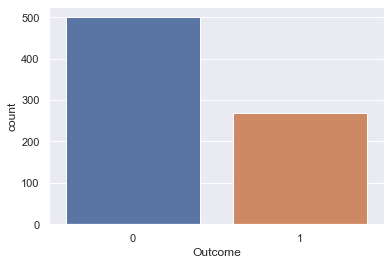

In [83]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

count    768.000000
mean       3.845052
std        3.369578
min        0.000000
1%         0.000000
5%         0.000000
10%        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
90%        9.000000
95%       10.000000
99%       13.000000
max       17.000000
Name: Pregnancies, dtype: float64


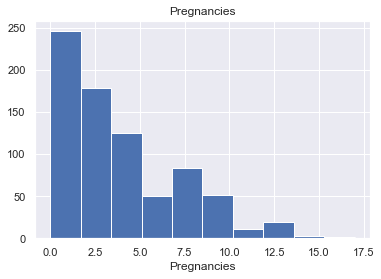

count    768.000000
mean     120.894531
std       31.972618
min        0.000000
1%        57.000000
5%        79.000000
10%       85.000000
25%       99.000000
50%      117.000000
75%      140.250000
90%      167.000000
95%      181.000000
99%      196.000000
max      199.000000
Name: Glucose, dtype: float64


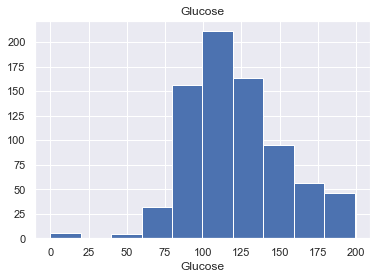

count    768.000000
mean      69.105469
std       19.355807
min        0.000000
1%         0.000000
5%        38.700000
10%       54.000000
25%       62.000000
50%       72.000000
75%       80.000000
90%       88.000000
95%       90.000000
99%      106.000000
max      122.000000
Name: BloodPressure, dtype: float64


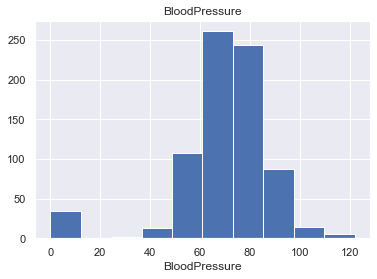

count    768.000000
mean      20.536458
std       15.952218
min        0.000000
1%         0.000000
5%         0.000000
10%        0.000000
25%        0.000000
50%       23.000000
75%       32.000000
90%       40.000000
95%       44.000000
99%       51.330000
max       99.000000
Name: SkinThickness, dtype: float64


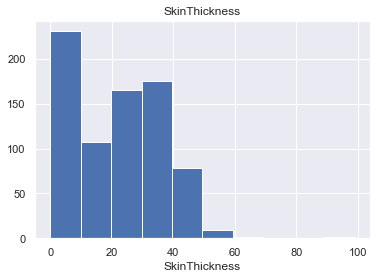

count    768.000000
mean      79.799479
std      115.244002
min        0.000000
1%         0.000000
5%         0.000000
10%        0.000000
25%        0.000000
50%       30.500000
75%      127.250000
90%      210.000000
95%      293.000000
99%      519.900000
max      846.000000
Name: Insulin, dtype: float64


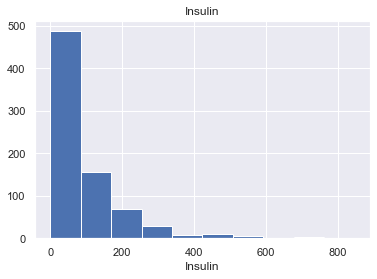

count    768.000000
mean      31.992578
std        7.884160
min        0.000000
1%         0.000000
5%        21.800000
10%       23.600000
25%       27.300000
50%       32.000000
75%       36.600000
90%       41.500000
95%       44.395000
99%       50.759000
max       67.100000
Name: BMI, dtype: float64


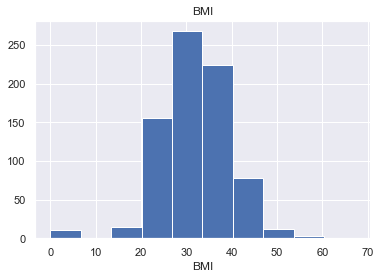

count    768.000000
mean       0.471876
std        0.331329
min        0.078000
1%         0.094680
5%         0.140350
10%        0.165000
25%        0.243750
50%        0.372500
75%        0.626250
90%        0.878600
95%        1.132850
99%        1.698330
max        2.420000
Name: DiabetesPedigreeFunction, dtype: float64


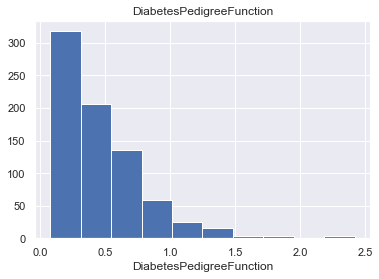

count    768.000000
mean      33.240885
std       11.760232
min       21.000000
1%        21.000000
5%        21.000000
10%       22.000000
25%       24.000000
50%       29.000000
75%       41.000000
90%       51.000000
95%       58.000000
99%       67.000000
max       81.000000
Name: Age, dtype: float64


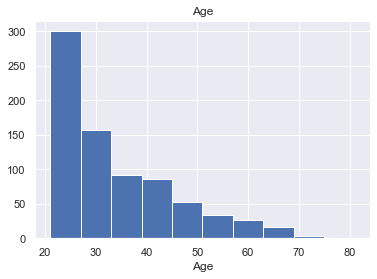

In [84]:
for col in num_cols:
    num_summary(df, col, plot=True)

**Analysis of numerical and categorical variables**

**Outcome** : Have the disease (1) or not (0). While approximately 35% have diabetes, 65% do not have diabetes.

**Pregnancies** : Few women have very high pregnancies. When we look at the 99% of pregnancies in the dataset, we see that 13 pregnancies are observed, well above the average value, while the maximum number of pregnancies is 17. This indicates that some women have had a higher-than-expected number of pregnancies, and these stand out as outliers.


**Glucose** : Glucose values are seen to be 0 at minimum and 199 at maximum. This indicates that the glucose values in the dataset span a fairly wide range. In particular, the minimum value of 0 indicates that there may be several outliers with a low glucose value. It will be examined whether the glucose value can be zero.


**BloodPressure** : Blood pressure values were observed as 0 at minimum and 122 at maximum. A minimum value of 0 can be considered as an outlier that may occur due to incorrect or incomplete measurements. (to be examined)


**SkinThickness** : Big difference between max value and 99% is there outlier here? raises the question (to be examined). In addition, when we look at the 25% slice, it is seen that the skin thickness values are zero. This may suggest that some patients' skin thickness is represented by incomplete measurements or indeed very low values.


**Insulin** : Big difference between max value and 99% is there outlier here? raises the question (to be examined).
When we look at the 25% of the variable, it is seen that the insulin values are zero. This may suggest that some patients' insulin levels are represented by incomplete measurements or indeed very low values.
It is seen that the minimum value of the variable is 0 and the maximum value is 846. This indicates that the insulin values are spread over a fairly wide range and some patients have insulin levels that are too low or too high for normal. Whether the insulin values can be 0 will be examined.


**BMI** : Body mass index is an important health indicator that evaluates body weight according to height. The average body mass index value in the data set was determined as 31.99. Because this value is over 30, it falls into the "obese" category. This indicates that most of the patients in the dataset may be obese or have high body mass index values. In terms of health, high body mass index values can be associated with obesity, which may increase some health risks. A value of 0 in the 1% portion will be examined.


**DiabetesPedigreeFunction** : Big difference between max value and 99% is there outlier here? raises the question (to be examined).

**Age** : Ages vary between 21 and 81. The average age value is seen as 33.24.

<hr style="border: 1px solid black; width: 99%; margin-left: 0;">


**Outcome** : Hastalığa sahip (1) ya da değil (0).  Yaklaşık %35 diyabet hastası iken %65 diyabet hastası değildir.

**Pregnancies** : Az sayıda kadın çok yüksek hamilelik sayılarına sahiptir. Veri kümesindeki hamileliklerin %99'lik dilimine baktığımızda, ortalama değerin oldukça üzerinde 13 hamilelik gözlemlenirken, maksimum hamilelik sayısının 17 olduğunu görüyoruz. Bu durum, bazı kadınların beklenenden daha yüksek sayıda hamilelik geçirdiğini ve bunların aykırı değerler olarak öne çıktığını gösterir.


**Glucose** : Glikoz değerlerinin minimumda 0 ve maksimumda 199 olduğu görülmektedir. Bu, veri kümesindeki glikoz değerlerinin oldukça geniş bir aralığa yayıldığını gösterir. Özellikle minimum değer olan  0, düşük glikoz değerine sahip birkaç aykırı gözlem olabileceğini gösterir.Glikoz degerinin sıfır olup olamayacağı incelenecek.


**BloodPressure** : Kan basıncı değerleri, minimumda 0 ve maksimumda 122 olarak gözlemlenmiştir. Minimum değerin 0 olması, belki de yanlış veya eksik ölçümler nedeniyle oluşabilecek aykırı bir durum olarak değerlendirilebilir.(incelenecek)


**SkinThickness** : Maksimum değer ile %99 arasında büyük bir fark olması burada aykırı değer var mı? sorusunu akla getirmektedir.(incelenecek). Ayrıca %25'lik dilimine baktığımızda , deri kalınlığı değerlerinin sıfır olduğu görülmektedir. Bu, bazı hastaların deri kalınlığının eksik ölçümlerle veya gerçekten çok düşük değerlerle temsil edildiğini düşündürebilir.(incelenecek).SkinThickness değerlerinin 0 olup olamayacağı incelenecek.


**Insulin** : Maksimum değer ile %99 arasında büyük bir fark olması burada aykırı değer var mı? sorusunu akla getirmektedir.(incelenecek).
Değişkenin %25'lik dilimine baktığımızda , insülin değerlerinin sıfır olduğu görülmektedir. Bu, bazı hastaların insülin düzeylerinin eksik ölçümlerle veya gerçekten çok düşük değerlerle temsil edildiğini düşündürebilir. 
Değişkenin minimum değeri 0 ve maksimum değeri 846 olduğu görülmektedir. Bu, insülin değerlerinin oldukça geniş bir aralığa yayıldığını ve bazı hastaların normalden çok düşük veya çok yüksek insülin düzeylerine sahip olduğunu gösterir.İnsulin değerlerinin 0 olup olamayacağı incelenecek.


**BMI** : Vücut kitle indeksi, vücut ağırlığını boyuna göre değerlendiren önemli bir sağlık göstergesidir. Veri setindeki ortalama vücut kitle indeksi değeri 31.99 olarak belirlenmiştir. Bu değer, 30'un üzerinde olması nedeniyle "obez" kategorisine girmektedir. Bu durum, veri kümesindeki hastaların çoğunun obez olabileceğini veya yüksek vücut kitle indeksi değerlerine sahip olduğunu göstermektedir. Sağlık açısından, yüksek vücut kitle indeksi değerleri, obezite ile ilişkilendirilebilir ve bu durum bazı sağlık risklerini artırabilir.%1 lik kısımdaki 0 değeri incelenecek.


**DiabetesPedigreeFunction** : Maksimum değer ile %99 arasında büyük bir fark olması burada aykırı değer var mı? sorusunu akla getirmektedir.(incelenecek).

**Age** : Yaşlar 21 ile 81 arasında değişmektedir. Ortalama yaş değeri 33.24 olarak görülmektedir. 

.

**Target variable analysis**

In [85]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")
    
for col in num_cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0           3.298000
1           4.865672


            Glucose
Outcome            
0        109.980000
1        141.257463


         BloodPressure
Outcome               
0            68.184000
1            70.824627


         SkinThickness
Outcome               
0            19.664000
1            22.164179


            Insulin
Outcome            
0         68.792000
1        100.335821


               BMI
Outcome           
0        30.304200
1        35.142537


         DiabetesPedigreeFunction
Outcome                          
0                        0.429734
1                        0.550500


               Age
Outcome           
0        31.190000
1        37.067164




In [86]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df, "Outcome", col)

         TARGET_MEAN
Outcome             
0                0.0
1                1.0




**Outcome** - **Pregnancies**

     The average pregnancy rate for people without diabetes is 3.29.
    
     The average pregnancy rate for people with diabetes is 4.84.

**Outcome** - **Glucose**

     The average glucose values of people without diabetes is 110.2.
    
     The average glucose values of people with diabetes is 141.53.

**Outcome** - **BloodPressure**

     The average blood pressure of people without diabetes is 69,508.
    
     The average blood pressure of people with diabetes is 72.88.
    
**Outcome** - **SkinThickness**

     The average skin thickness of people without diabetes is 19.66.
    
     The average skin thickness of people with diabetes is 22.09.

**Outcome** - **Insulin**

     Insulin values averaged 65.11 for people without diabetes.
    
     The average insulin values of people with diabetes are 89.58.

**Outcome** - **BMI**

     The average BMI of people without diabetes is 30.52.
    
     The average BMI of people with diabetes is 35.10.
    
**Outcome** - **DiabetesPedigreeFunction**

     The average DiabetesPedigreeFunction values of people without diabetes is 0.42.
    
     The average DiabetesPedigreeFunction values of people with diabetes is 0.53.

**Outcome** - **Age**

     The average age of people without diabetes is 31.13.
    
     The average age of people with diabetes is 37.05.

<hr style="border: 1px solid black; width: 99%; margin-left: 0;">


**Outcome** - **Pregnancies**

    diyabet olmayan kişilerin hamile kalma ortalaması 3.29'dur.
    
    diyabet olan kişilerin hamile kalma ortalaması: 4.84'tür.

**Outcome** - **Glucose**

    diyabet olmayan kişilerin glikoz değerlerinin ortalaması 110.2'dir.
    
    diyabet olan kişilerin glikoz değerlerinin ortalaması 141.53'tür.

**Outcome** - **BloodPressure**

    diyabet olmayan kişilerin kan basıncı ortalaması 69.508'dir.
    
    diyabet olan kişilerin kan basıncı ortalaması 72.88'dir.
    
**Outcome** - **SkinThickness**

    diyabet olmayan kişilerin cilt kalınlığı ortalaması 19.66'dır.
    
    diyabet olan kişilerin cilt kalınlığı ortalaması 22.09'dur.

**Outcome** - **Insulin**

    diyabet olmayan kişilerin Insulin değerlerinin ortalaması 65.11'dir.
    
    diyabet olan kişilerin Insulin değerlerinin ortalaması 89.58'dir.

**Outcome** - **BMI**

    diyabet olmayan kişilerin BMI ortalaması 30.52'dir.
    
    diyabet olan kişilerin BMI ortalaması 35.10'dur.
    
**Outcome** - **DiabetesPedigreeFunction**

    diyabet olmayan kişilerin DiabetesPedigreeFunction değerlerinin ortalaması 0.42'dir.
    
    diyabet olan kişilerin DiabetesPedigreeFunction değerlerinin ortalaması 0.53'tür.

**Outcome** - **Age**

    diyabet olmayan kişilerin yaş ortalaması 31.13'tür.
    
    diyabet olan kişilerin yaş ortalaması 37.05'tir.

.

# • Outliers

In [87]:
for col in df.columns:
    low, up = outlier_thresholds(df, col)
    print(f"Up and Low limit for '{col}': {low}, {up}")

Up and Low limit for 'Pregnancies': -6.5, 13.5
Up and Low limit for 'Glucose': 37.125, 202.125
Up and Low limit for 'BloodPressure': 35.0, 107.0
Up and Low limit for 'SkinThickness': -48.0, 80.0
Up and Low limit for 'Insulin': -190.875, 318.125
Up and Low limit for 'BMI': 13.35, 50.550000000000004
Up and Low limit for 'DiabetesPedigreeFunction': -0.32999999999999996, 1.2
Up and Low limit for 'Age': -1.5, 66.5
Up and Low limit for 'Outcome': -1.5, 2.5


In [88]:
for col in num_cols:
    print(col, check_outlier(df, col))

Pregnancies True
Glucose True
BloodPressure True
SkinThickness True
Insulin True
BMI True
DiabetesPedigreeFunction True
Age True


<AxesSubplot:>

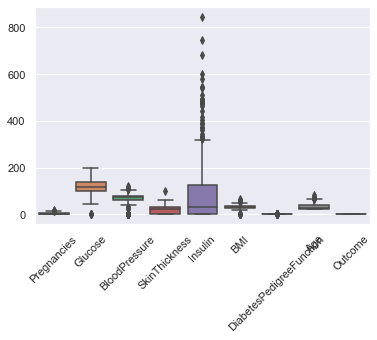

In [89]:
sns.set()
plt.xticks(rotation=45)
sns.boxplot(data=df)

In [90]:
for col in num_cols:
    print(f"grab_outliers '{col}': {grab_outliers(df, col)}")

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
88            15      136             70             32      110  37.1   
159           17      163             72             41      114  40.9   
298           14      100             78             25      184  36.6   
455           14      175             62             30        0  33.6   

     DiabetesPedigreeFunction  Age  Outcome  
88                      0.153   43        1  
159                     0.817   47        1  
298                     0.412   46        1  
455                     0.212   38        1  
grab_outliers 'Pregnancies': None
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
75             1        0             48             20        0  24.7   
182            1        0             74             20       23  27.7   
342            1        0             68             35        0  32.0   
349            5        0             80             32        0  41.

After outliers are caught, they are replaced with threshold values (low, up).

In [91]:
for col in num_cols:
    replace_with_thresholds(df, col)

In [92]:
for col in num_cols:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


Outliers suppressed.

# •Missing values analysis

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


<AxesSubplot:>

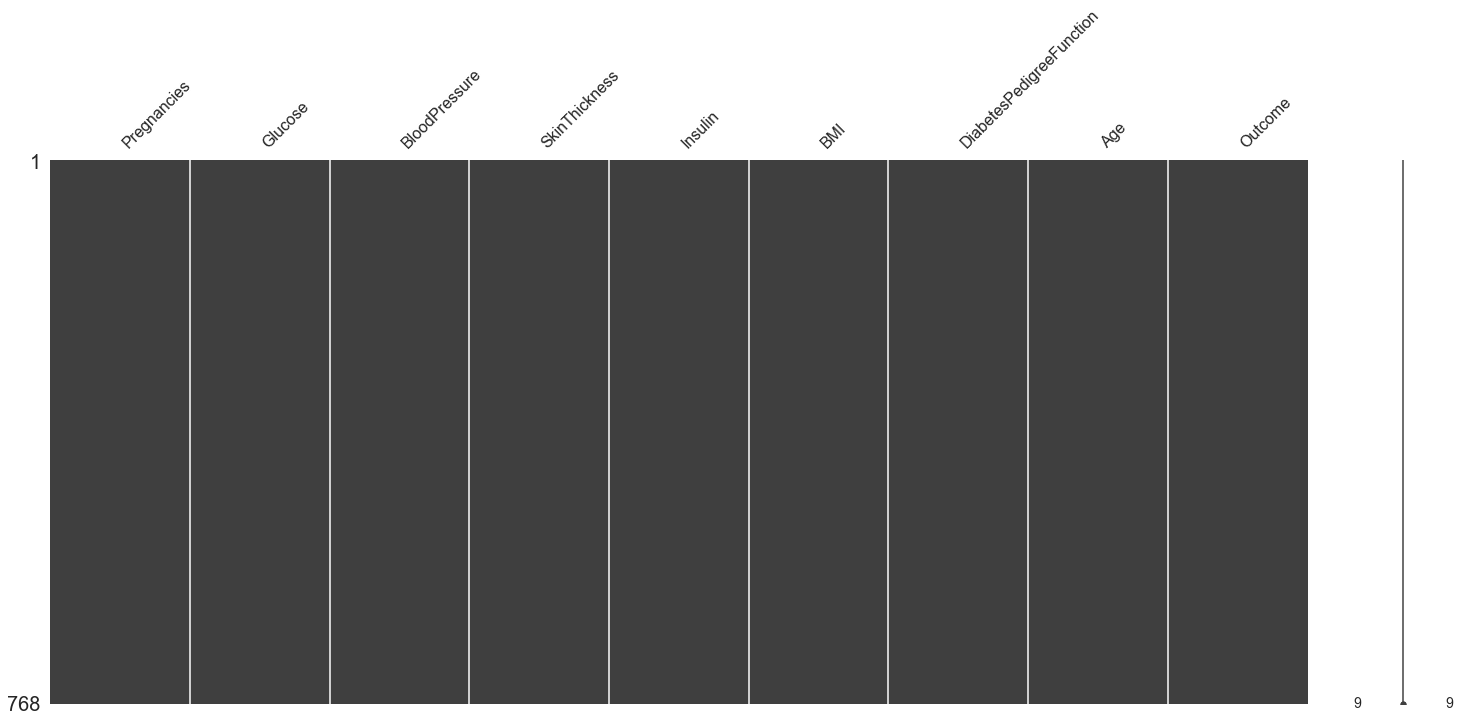

In [93]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns
    
missing_values_table(df, True)
msno.matrix(df)

There are no missing observations.

# •Correlation analysis

Correlation analysis is a statistical method used to measure and understand the relationship between two or more variables. This analysis helps determine how strong the relationship between variables is and its direction (positive, negative, or none). Correlation analysis is widely used in various fields, from scientific research to data analysis in businesses.

There are two main types of correlation coefficients used in correlation analysis: the Pearson correlation coefficient and the Spearman rank correlation coefficient.

Pearson Correlation Coefficient: The Pearson correlation coefficient measures the linear relationship between two continuous variables. This coefficient is used when both variables are normally distributed and measured on a continuous scale. Its values typically range from -1 to +1:
+1 represents a perfect positive correlation (when one variable increases, the other variable also increases linearly).
-1 represents a perfect negative correlation (when one variable increases, the other variable decreases linearly).
0 indicates no relationship between the variables (no correlation).

Spearman Rank Correlation Coefficient: The Spearman rank correlation coefficient measures the relationship between ranked data. This method is preferred when the data is ranked or measured on an ordinal scale, and it determines the monotonic relationship between variables. Similar to the Pearson correlation coefficient, its values range from -1 to +1.

<hr style="border: 1px solid black; width: 99%; margin-left: 0;">


Korelasyon analizi, iki veya daha fazla değişken arasındaki ilişkiyi ölçmek ve anlamak için kullanılan istatistiksel bir yöntemdir. Bu analiz, değişkenler arasındaki ilişkinin ne kadar güçlü olduğunu ve bu ilişkinin yönünü (pozitif, negatif veya yok) belirlemeye yardımcı olur. Korelasyon analizi, bilimsel araştırmalardan işletmelerin veri analizine kadar birçok alanda yaygın olarak kullanılmaktadır.

Korelasyon analizi, iki ana tip korelasyon katsayısı kullanılarak gerçekleştirilir: Pearson korelasyon katsayısı ve Spearman sıra korelasyon katsayısı.

Pearson Korelasyon Katsayısı: Pearson korelasyon katsayısı, iki sürekli değişken arasındaki doğrusal ilişkiyi ölçer. Bu katsayı, her iki değişkenin de normal dağıldığı ve sürekli ölçekle ölçüldüğü durumlarda kullanılır. Değerleri genellikle -1 ile +1 arasında değişir:
+1, mükemmel pozitif korelasyonu temsil eder (bir değişken artarken diğer değişken de doğrusal olarak artar).
-1, mükemmel negatif korelasyonu temsil eder (bir değişken artarken diğer değişken doğrusal olarak azalır).
0, değişkenler arasında bir ilişki olmadığını gösterir (korelasyon yok).

Spearman Sıra Korelasyon Katsayısı: Spearman katsayısı, sıralı veriler arasındaki ilişkiyi ölçer. Bu yöntem, verilerin sıralı veya düzey ölçekli olduğu durumlarda tercih edilir ve değişkenler arasındaki monotonik ilişkiyi belirler. Pearson korelasyon katsayısı gibi, değerleri -1 ile +1 arasında değişir.

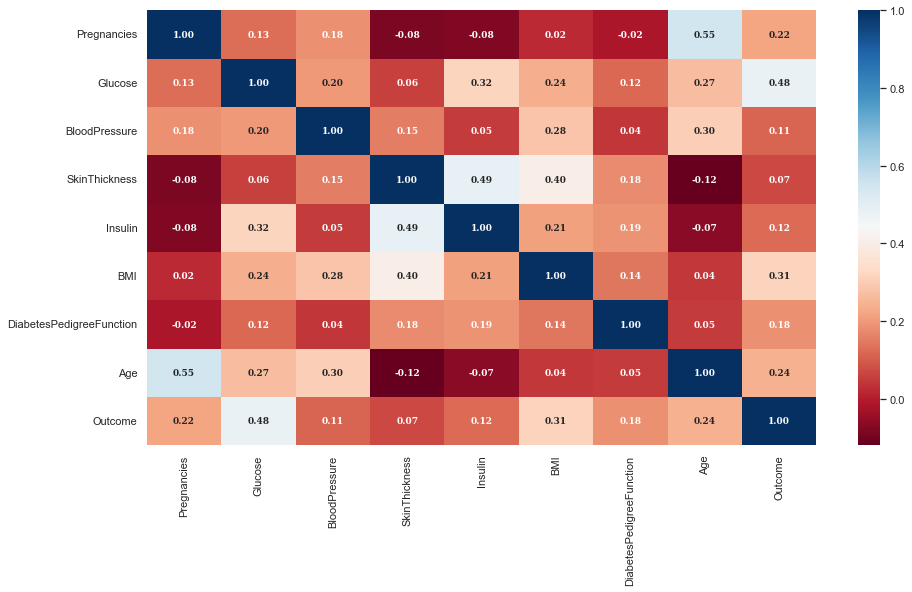

In [94]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(method= 'pearson'),annot=True,fmt=".2f",
                cmap="RdBu",
                annot_kws={
                       "fontsize":9,
                       "fontweight":"bold",
                       "fontfamily":"serif"});

high correlation control.

In [95]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

high_correlated_cols(df)

[]

There is no variable with a high correlation value.

<h2 id="--THANK-YOU-"><div style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://w0.peakpx.com/wallpaper/957/661/HD-wallpaper-white-marble-white-stone-texture-marble-stone-background-white-stone.jpg)"><b><span style="color:black">BASİC MODEL</span></b> </div><a class="anchor-link" href="https://www.kaggle.com/code/mersaidylmaz/diabetes-predict-of-machine-learning#--THANK-YOU-" target="_self" rel=" noreferrer nofollow">¶</a></h2>

In [96]:
X = df.drop("Outcome" , axis = 1)
y = df["Outcome"]
### Verinin Test ve Train olarak ayrılması
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=46)

In [97]:
## Random Forest İle Model Kurma Ve Tahmin İşlemi
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)    
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 3)}")
print(f"Auc: {round(roc_auc_score(y_pred, y_test), 3)}")

Accuracy: 0.723
Auc: 0.697


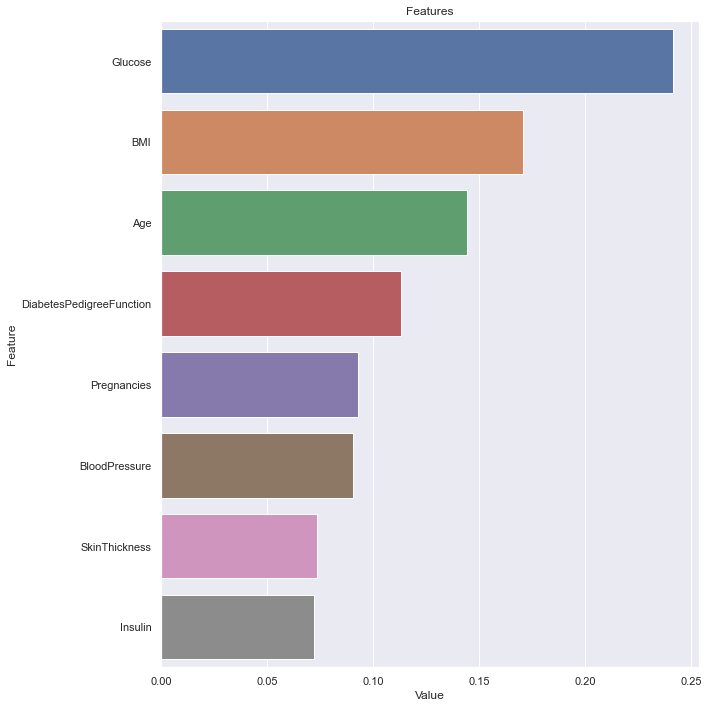

In [98]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save :
        plt.savefig('importances.png')

plot_importance(rf_model, X_train)

# Feature Engineering

Examining and editing missing or incorrect information in data.

Blood Pressure Glucose BMI Insulin --> 0 values will be examined.

**BloodPressure** : Although blood pressure differs from person to person, the ideal systolic blood pressure is in the range of 120 to 130 mmHg. Diastolic blood pressure, known as diastolic blood pressure, is considered to be in the range of 80-90 mmHg.


**BMI** : 0 – 18.4 kg/m²: Weak. In this case, the individual should gain weight in a healthy way under the leadership of a dietitian. It can also be a sign of various diseases such as osteoporosis, weakening of the immune system and anemia.

18.5 – 24.9 kg/m²: Normal weight. It is the ideal weight range for the individual. And he should continue to have a balanced and regular diet and healthy activities.

25 – 29.9 kg/m²: Overweight. And the individual should reduce his weight to normal with the most suitable diet and sports for him.

30 – 34.9 kg/m²: 1st degree obesity. Since her weight is a threat to her health, she should lose weight under the supervision of a dietitian.

35 – 39.99 kg/m²: 2nd degree obesity. The risk of cardiovascular diseases increases. Lose weight with a dietitian.

40+ kg/m²: 3rd degree obesity. Many diseases reside in morbid obesity. These include diseases such as type 2 diabetes and hypertension. And they are at great risk. In addition, it is necessary to lose weight under the joint supervision of a dietitian and doctor. At this point, it is necessary to make a serious treatment plan. In addition, people over 50 are considered super obese.


**Insulin** :
Insulin levels are typically low in the fasting state and increase after eating. Normal values of insulin levels can be expressed in units of microIU/mL or picomoles/L. However, reference ranges may differ between laboratories. Typically, insulin levels in the fasting state should be in the range of about 5-15 microIU/mL (35-105 picomol/L) in adults.

**Glucose** :
Glucose levels in the blood change during fasting and after meals. Normal glucose values are expressed in units of milligrams/dL (mg/dL). In the fasting state, the normal glucose level in adults should generally be between 70-100 mg/dL (3.9-5.6 mmol/L). Hyperglycemia is higher than normal blood glucose. Hyperglycemia is mentioned when fasting blood glucose exceeds 100 mg/dl and postprandial blood glucose exceeds 140 mg/dl. It is frequently observed in diabetic patients who receive inadequate treatment or do not receive treatment. A postprandial blood glucose above 200 mg/dl indicates diabetes.

In line with this information, we will change the 0 values to nan values

<hr style="border: 1px solid black; width: 99%; margin-left: 0;">

Verideki eksik veya yanlış bilgilerin incelenmesi ve düzenlenmesi.

BloodPressure  Glucose  BMI   Insulin --> 0 değerleri incelenecek 

**BloodPressure** : Kan basıncı, kişiden kişiye farklılık gösterse de ideal sistolik kan basıncı 120 ila 130 mmHg aralığındadır. Küçük tansiyon olarak bilinen diyastolik kan basıncının ise 80-90 mmHg aralığında olması ideal seviye olarak kabul edilir.


**BMI** : 0 – 18,4 kg/m²: Zayıf. Bu durumda bireyin diyetisyen önderliğinde sağlıklı bir şekilde kilo almalıdır. Aynı zamanda kemik erimesi, bağışıklık sisteminin zayıflaması ve anemi gibi çeşitli hastalıkların bulunduğuna işaret olabilir.

18,5 – 24,9 kg/m²: Normal kilolu. Birey için ideal kilo aralığıdır. Ve dengeli ve düzenli beslenmesine ve sağlıklı aktivitelerine devam etmelidir.

25 – 29,9 kg/m²: Fazla kilolu. Ve birey kendisi için en uygun diyet ve sporla kilosunu normale indirmelidir.

30 – 34,9 kg/m²: 1. derece obezite. Kilosu, sağlığı açısından tehdit oluşturduğundan diyetisyen gözetiminde kilo vermelidir.

35 – 39,99 kg/m²: 2. derece obezite. Kalp ve damar hastalıkları görülme olasılığı artar. Diyetisyen eşliğinde kilo vermelidir.

40+ kg/m²: 3. derece obezite. Pek çok hastalık morbid obezitede barınır. Bunların içinde tip 2 diyabet hipertansiyon gibi hastalıklar vardır. Ve büyük risk altındadırlar. Ayrıca diyetisyen ve doktorun ortak gözetiminde kilo vermesi gerekir. Bu noktada ciddi bir tedavi planı yapılması gereklidir. Ayrıca 50 üzeri durumlar da süper obez olarak değerlendirilir.


**Insulin** :
İnsülin seviyeleri açlık durumunda tipik olarak düşüktür ve yemek yendikten sonra artar. İnsülin seviyelerinin normal değerleri, birim olarak mikroIU/mL veya picomol/L cinsinden ifade edilebilir. Ancak, laboratuvarlar arasında referans aralıklar farklılık gösterebilir. Tipik olarak açlık durumunda insülin seviyeleri yetişkinlerde yaklaşık 5-15 mikroIU/mL (35-105 picomol/L) aralığında olmalıdır.

**Glucose** :
Kandaki glukoz seviyeleri açlık durumunda ve yemeklerden sonra değişir. Normal glukoz değerleri, birim olarak miligram/dL (mg/dL) cinsinden ifade edilir. Açlık durumunda normal glukoz seviyesi yetişkinlerde genellikle 70-100 mg/dL (3.9-5.6 mmol/L) arasında olmalıdır. Hiperglisemi kan glukozunun normalden yüksek olmasıdır. Açlık kan glukozu 100 mg/dl'yi, tokluk kan glukozu ise 140 mg/dl’yi geçtiğinde hiperglisemiden söz edilir. Sıklıkla yetersiz tedavi alan veya tedavi almayan şeker hastalarında gözlenir. Tokluk kan glukozunun 200 mg/dl üzerinde olması şeker hastalığına işaret eder. 



Bu bilgiler doğrultusunda 0 değerlerini nan değer olarak değiştireceğiz.

**Changing 0 values to nan values.**

In [99]:
zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "DiabetesPedigreeFunction", "Outcome"])]

In [100]:
for col in zero_columns:
    df[col] = np.where(df[col] == 0, np.nan, df[col])

**Missing value check.**

In [101]:
missing_values_table(df)

               n_miss  ratio
Insulin           374  48.70
SkinThickness     227  29.56


<AxesSubplot:>

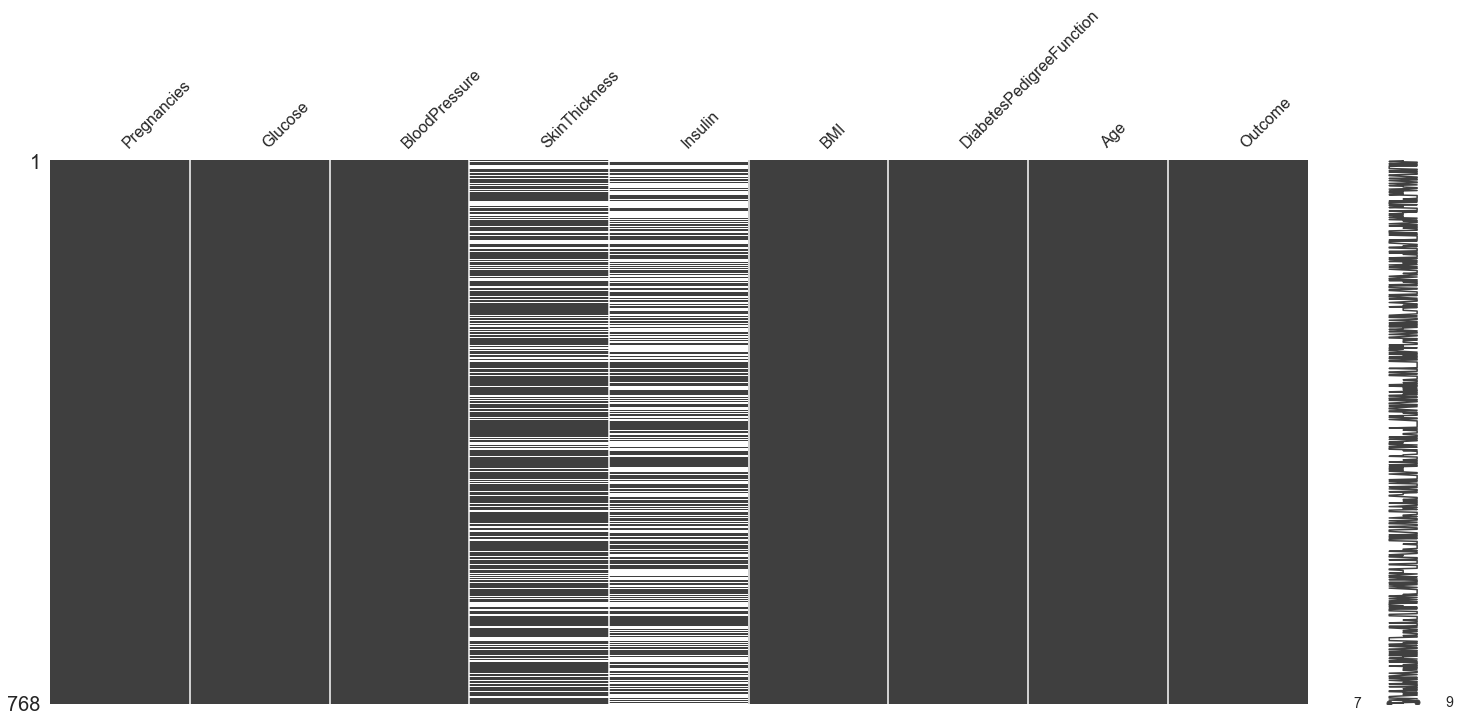

In [102]:
msno.matrix(df)

**Filling the missing values with the median.**

In [103]:
df = df.apply(lambda x: x.fillna(x.median()), axis=0)  

In [104]:
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


<AxesSubplot:>

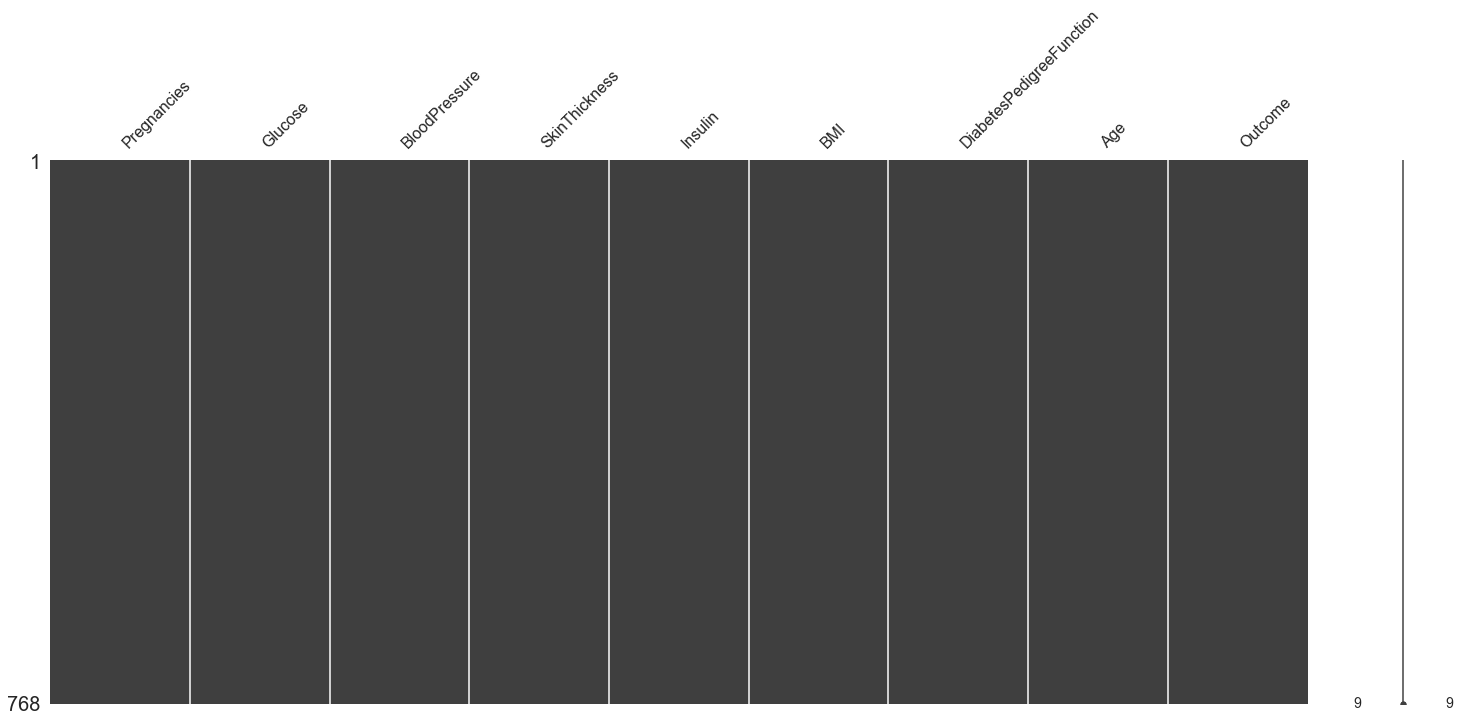

In [105]:
msno.matrix(df)

**Outlier check.**

In [106]:
for col in num_cols:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness True
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False


<AxesSubplot:>

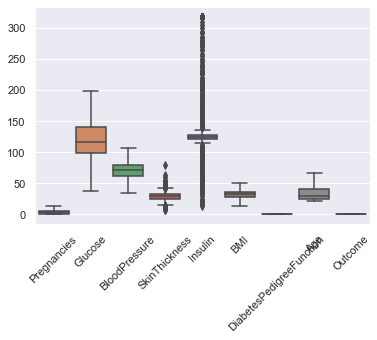

In [107]:
sns.set()
plt.xticks(rotation=45)
sns.boxplot(data=df)

In [108]:
for col in num_cols:
    replace_with_thresholds(df, col)

In [109]:
for col in num_cols:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


<AxesSubplot:>

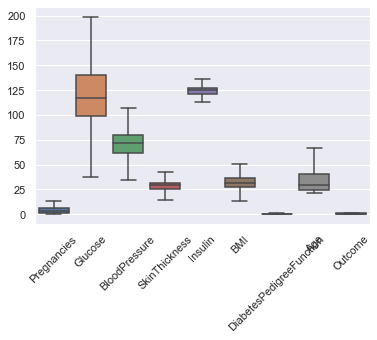

In [110]:
sns.set()
plt.xticks(rotation=45)
sns.boxplot(data=df)

Outliers problem solved.

**Feature Extraction**

**Age**


In [111]:
df.loc[(df["Age"] >= 21) & (df["Age"] <= 50), "NEW_AGE_CAT"] = "mature"
df.loc[(df["Age"] > 50), "NEW_AGE_CAT"] = "senior"

In [112]:
df.groupby("NEW_AGE_CAT").agg({"Outcome":["mean","count"]})

Outcome      
                 mean count
NEW_AGE_CAT                
mature       0.334789   687
senior       0.469136    81

Those who are mature are less likely to have diabetes (0.33) than those who are seniors (0.469).

Ho: There is no difference between the distribution of the population from which the sample was drawn and the normal distribution.

Hs: There is a difference between the distribution of the population from which the sample was drawn and the normal distribution.

In [113]:
from scipy.stats import kstest

statistic, p_value = kstest(rvs=df['NEW_AGE_CAT'] == "senior", cdf="norm", alternative='two-sided', mode='auto')

print("p_value :",p_value)

p_value : 4.565991166283496e-178


In [114]:
from scipy.stats import kstest

statistic, p_value = kstest(rvs=df['NEW_AGE_CAT'] == "mature", cdf="norm", alternative='two-sided', mode='auto')

print("p_value :",p_value)

p_value : 0.0


Ho was rejected. There is a difference between the distribution of the sample from which the sample was drawn and the normal distribution.

.

Ho: There is no significant difference between the groups.

H1: At least one group is statistically different from other groups.

In [115]:
import pandas as pd
from scipy.stats import kruskal

# Kruskal-Wallis testini gerçekleştirme
statistic, p_value = kruskal(df['NEW_AGE_CAT'] == "mature", df['NEW_AGE_CAT'] == "senior")

# Sonuçları yazdırma
print("Test İstatistiği:", statistic)
print("p değeri:", p_value)

Test İstatistiği: 955.7211303710947
p değeri: 7.570327279720894e-210


Ho was rejected.. At least one group is statistically different from the other groups.

For more, you can visit https://github.com/yasin-cnd/Statistics-Istatistik-.

**Glucose**

In [116]:
df["NEW_GLUCOSE"] = pd.cut(x=df["Glucose"], bins=[0, 140, 200, 300], labels=["Normal", "Hiperglisemi", "Diabetes"])

Note: Hyperglycemia is the condition where blood glucose levels are higher than normal.

In [117]:
df.groupby("NEW_GLUCOSE").agg({"Outcome": ["mean","count"]})

Outcome      
                  mean count
NEW_GLUCOSE                 
Normal        0.236111   576
Hiperglisemi  0.687500   192
Diabetes           NaN     0

Those with hyperglycemia are more likely to have diabetes than those with normal glucose levels.

Ho: There is no difference between the distribution of the population from which the sample was drawn and the normal distribution.

Hs: There is a difference between the distribution of the population from which the sample was drawn and the normal distribution.

In [118]:
from scipy.stats import kstest

statistic, p_value = kstest(rvs=df["NEW_GLUCOSE"] == "Normal", cdf="norm", alternative='two-sided', mode='auto')

print("p_value :",p_value)

p_value : 1.7901449330416085e-256


In [119]:
from scipy.stats import kstest

statistic, p_value = kstest(rvs= df["NEW_GLUCOSE"] == "Hiperglisemi", cdf="norm", alternative='two-sided', mode='auto')

print("p_value :",p_value)

p_value : 4.565991166283496e-178


In [120]:
from scipy.stats import kstest

statistic, p_value = kstest(rvs= df["NEW_GLUCOSE"] == "Diabetes", cdf="norm", alternative='two-sided', mode='auto')

print("p_value :",p_value)

p_value : 4.565991166283496e-178


Ho was rejected. There is a difference between the distribution of the sample from which the sample was drawn and the normal distribution.

.

Ho: There is no significant difference between the groups.

H1: At least one group is statistically different from other groups.

In [121]:
import pandas as pd
from scipy.stats import kruskal

# Kruskal-Wallis testini gerçekleştirme
statistic, p_value = kruskal(df["NEW_GLUCOSE"] == "Normal" , df["NEW_GLUCOSE"] == "Hiperglisemi" , df["NEW_GLUCOSE"] == "Diabetes")

# Sonuçları yazdırma
print("Test İstatistiği:", statistic)
print("p değeri:", p_value)

Test İstatistiği: 1007.5625000000005
p değeri: 1.6239888333434433e-219


Ho was rejected. At least one group is statistically different from the other groups.

**BMI**

In [122]:
df['NEW_BMI'] = pd.cut(x=df['BMI'], bins=[0, 18.5, 25, 30, 35, 40, df["BMI"].max()],
                       labels=["Underweight", "Healthy", "Overweight", "1 degree obese", "2 degree obese", "3 degree obese"])

In [123]:
df.groupby("NEW_BMI").agg({"Outcome": ["mean","count"]})

Outcome      
                    mean count
NEW_BMI                       
Underweight     0.133333    15
Healthy         0.064815   108
Overweight      0.244444   180
1 degree obese  0.452489   221
2 degree obese  0.412162   148
3 degree obese  0.562500    96

It can be said that there is a partially linear relationship between an increase in BMI and having diabetes.

**BloodPressure**

In [124]:
df['NEW_BloodPressure'] = pd.cut(x=df['BloodPressure'], bins=[0, 80, 90, 122 ],
                       labels=["Normal", "prehypertension", "hypertension"])

In [125]:
df.groupby("NEW_BloodPressure").agg({"Outcome": ["mean","count"]})

Outcome      
                       mean count
NEW_BloodPressure                
Normal             0.316750   603
prehypertension    0.464567   127
hypertension       0.473684    38

The higher the blood pressure, the higher the probability of having diabetes.

**Insulin**

In [126]:
def set_insulin(dataframe, col_name):
    dataframe["Insulin_CAT"] = dataframe[col_name].apply(lambda x: "Normal" if 16 <= x <= 166 else "Anormal")
set_insulin(df,"Insulin")    

In [127]:
df.groupby("Insulin_CAT").agg({"Outcome": ["mean","count"]})

Outcome      
                 mean count
Insulin_CAT                
Normal       0.348958   768

There is no negative situation in insulin values.all values are normal.

**AGE-BMI**

In [128]:
# # Yaş ve beden kitle indeksini bir arada düşünerek kategorik değişken oluşturma
df.loc[(df["BMI"] < 18.5) & ((df["Age"] >= 21) & (df["Age"] <= 50)), "NEW_AGE_BMI"] = "underweight_mature"
df.loc[(df["BMI"] < 18.5) & (df["Age"] > 50), "NEW_AGE_BMI"] = "underweight_senior"

df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & ((df["Age"] >= 21) & (df["Age"] <= 50)), "NEW_AGE_BMI"] = "healthy_mature"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & (df["Age"] > 50), "NEW_AGE_BMI"] = "healthy_senior"


df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & ((df["Age"] >= 21) & (df["Age"] <= 50)), "NEW_AGE_BMI"] = "overweight_mature"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & (df["Age"] > 50), "NEW_AGE_BMI"] = "overweight_senior"


df.loc[((df["BMI"] >= 30) & (df["BMI"] < 35)) & ((df["Age"] >=21) & (df["Age"] <= 50)), "NEW_AGE_BMI"] = "1_obese_mature"
df.loc[((df["BMI"] >= 30) & (df["BMI"] < 35)) & (df["Age"] > 50), "NEW_AGE_BMI"] = "1_obese_senior"

df.loc[((df["BMI"] >= 35) & (df["BMI"] < 40)) & ((df["Age"] >=21) & (df["Age"] <= 50)), "NEW_AGE_BMI"] = "2_obese_mature"
df.loc[((df["BMI"] >= 35) & (df["BMI"] < 40)) & (df["Age"] > 50), "NEW_AGE_BMI"] = "2_obese_senior"

df.loc[((df["BMI"] >= 40) & (df["BMI"] < 100)) & ((df["Age"] >=21) & (df["Age"] <= 50)), "NEW_AGE_BMI"] = "3_obese_mature"
df.loc[((df["BMI"] >= 40) & (df["BMI"] < 100)) & (df["Age"] > 50), "NEW_AGE_BMI"] = "3_obese_senior"

In [129]:
df.groupby("NEW_AGE_BMI").agg({"Outcome": ["mean","count"]})

Outcome      
                        mean count
NEW_AGE_BMI                       
1_obese_mature      0.424390   205
1_obese_senior      0.736842    19
2_obese_mature      0.384615   130
2_obese_senior      0.650000    20
3_obese_mature      0.563830    94
3_obese_senior      0.500000     4
healthy_mature      0.045977    87
healthy_senior      0.200000    15
overweight_mature   0.221519   158
overweight_senior   0.238095    21
underweight_mature  0.076923    13
underweight_senior  0.500000     2

While healthy and mature people are less likely to have diabetes, those who are 1 degree obese senior have a high risk of diabetes.

.

# Encoding 

In [130]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 15
cat_cols: 7
num_cols: 8
cat_but_car: 0
num_but_cat: 4


In [131]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [132]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]

In [133]:
for col in binary_cols:
    df = label_encoder(df, col)

In [134]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT,NEW_GLUCOSE,NEW_BMI,NEW_BloodPressure,Insulin_CAT,NEW_AGE_BMI
0,6.0,148.0,72,35.0,125.000,33.6,0.627,50.0,1,0,Hiperglisemi,1 degree obese,Normal,Normal,1_obese_mature
1,1.0,85.0,66,29.0,125.000,26.6,0.351,31.0,0,0,Normal,Overweight,Normal,Normal,overweight_mature
2,8.0,183.0,64,29.0,125.000,23.3,0.672,32.0,1,0,Hiperglisemi,Healthy,Normal,Normal,healthy_mature
3,1.0,89.0,66,23.0,112.875,28.1,0.167,21.0,0,0,Normal,Overweight,Normal,Normal,overweight_mature
4,0.0,137.0,40,35.0,135.875,43.1,1.200,33.0,1,0,Normal,3 degree obese,Normal,Normal,3_obese_mature


In [135]:
categorical_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Outcome"]]
categorical_cols

['Insulin_CAT', 'NEW_AGE_BMI', 'NEW_GLUCOSE', 'NEW_BMI', 'NEW_BloodPressure']

In [136]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [137]:
df = one_hot_encoder(df, categorical_cols, drop_first=True)

In [138]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT,...,NEW_AGE_BMI_underweight_senior,NEW_GLUCOSE_Hiperglisemi,NEW_GLUCOSE_Diabetes,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_1 degree obese,NEW_BMI_2 degree obese,NEW_BMI_3 degree obese,NEW_BloodPressure_prehypertension,NEW_BloodPressure_hypertension
0,6.0,148.0,72,35.0,125.000,33.6,0.627,50.0,1,0,...,0,1,0,0,0,1,0,0,0,0
1,1.0,85.0,66,29.0,125.000,26.6,0.351,31.0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,8.0,183.0,64,29.0,125.000,23.3,0.672,32.0,1,0,...,0,1,0,1,0,0,0,0,0,0
3,1.0,89.0,66,23.0,112.875,28.1,0.167,21.0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0.0,137.0,40,35.0,135.875,43.1,1.200,33.0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [139]:
df.shape

(768, 30)

# Scaling

StandardScaler: Changed so that its Average is 0 and its Standard Deviation is 1.

In [140]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [141]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT,...,NEW_AGE_BMI_underweight_senior,NEW_GLUCOSE_Hiperglisemi,NEW_GLUCOSE_Diabetes,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_1 degree obese,NEW_BMI_2 degree obese,NEW_BMI_3 degree obese,NEW_BloodPressure_prehypertension,NEW_BloodPressure_hypertension
0,0.647150,0.861926,0.092691,0.824667,0.039062,0.209359,0.588927,1.445691,1,0,...,0,1,0,0,0,1,0,0,0,0
1,-0.848970,-1.159433,-0.330201,0.017945,0.039062,-0.784254,-0.378101,-0.189304,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1.245598,1.984903,-0.471166,0.017945,0.039062,-1.252672,0.746595,-0.103252,1,0,...,0,1,0,1,0,0,0,0,0,0
3,-0.848970,-1.031093,-0.330201,-0.788777,-1.494110,-0.571337,-1.022787,-1.049828,0,0,...,0,0,0,0,1,0,0,0,0,0
4,-1.148194,0.508990,-2.162737,0.824667,1.414175,1.557835,2.596563,-0.017199,1,0,...,0,0,0,0,0,0,0,1,0,0


# MODEL

<h2 id="--THANK-YOU-"><div style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://w0.peakpx.com/wallpaper/957/661/HD-wallpaper-white-marble-white-stone-texture-marble-stone-background-white-stone.jpg)"><b><span style="color:black">MODEL</span></b> </div><a class="anchor-link" href="https://www.kaggle.com/code/mersaidylmaz/diabetes-predict-of-machine-learning#--THANK-YOU-" target="_self" rel=" noreferrer nofollow">¶</a></h2>

In [142]:
y = df["Outcome"]
X = df.drop("Outcome", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred, y_test), 2)}")
print(f"Precision: {round(precision_score(y_pred, y_test), 2)}")
print(f"F1: {round(f1_score(y_pred, y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred, y_test), 2)}")

Accuracy: 0.78
Recall: 0.72
Precision: 0.62
F1: 0.67
Auc: 0.77


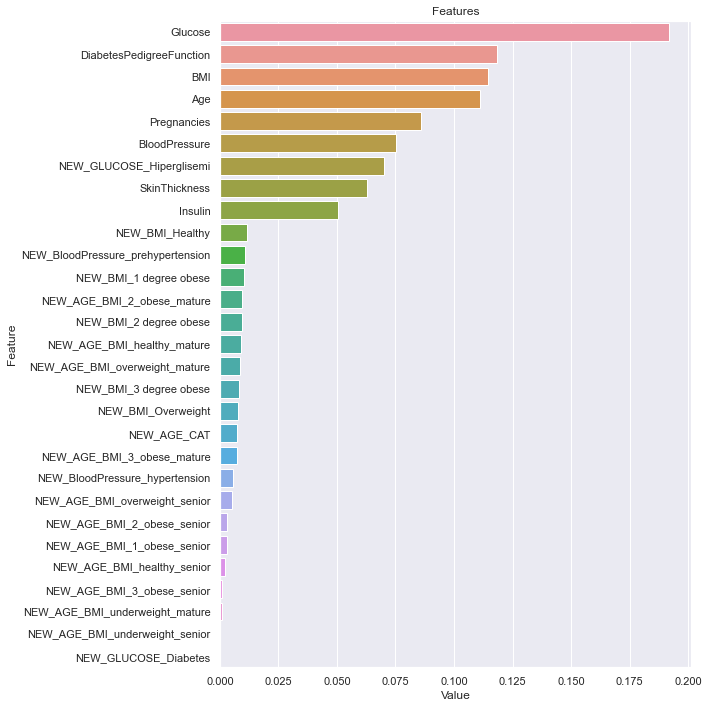

In [143]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save :
        plt.savefig('importances.png')

plot_importance(rf_model, X_train)

In [144]:
rf_params = {"n_estimators" :[100,200,500,1000], 
             "max_features": [3,5,7], 
             "min_samples_split": [2,5,10,30],
            "max_depth": [3,5,8,None]}

In [145]:
rf_model = RandomForestClassifier(random_state =321)

In [146]:
gs_cv = GridSearchCV(rf_model, 
                    rf_params,
                    cv = 5,
                    n_jobs = -1,
                    verbose = 2).fit(X, y)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


In [147]:
gs_cv.best_params_

{'max_depth': None,
 'max_features': 7,
 'min_samples_split': 2,
 'n_estimators': 200}

In [148]:
rf_tuned = RandomForestClassifier(**gs_cv.best_params_)

In [149]:
rf_tuned.fit(X_train , y_train)
y_pred_tuned = rf_tuned.predict(X_test)

In [150]:
from sklearn.model_selection import cross_val_score
cross_val_score(rf_tuned, X, y, cv = 5).mean()

0.7513623631270689

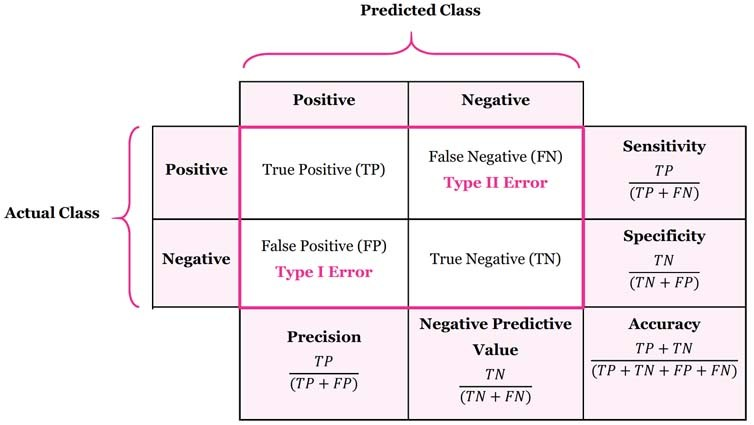

accuracy_score: A performance metric that measures the proportion of samples that the classification model predicts correctly across all samples.

Precision: Precision is a measure of how many true positive predictions are actually correct. It is defined as the number of true positives (TP) divided by the sum of true positives (TP) and false positives (FP).

Recall: Recall, Recall (or Sensitivity) is a measure of how many true positive cases are correctly identified. It is defined as the number of true positives (TP) divided by the sum of true positives (TP) and false negatives (FN).

F1-Score: The F1 score is the harmonic mean of Precision and Recall and tries to find the balance between precision and recall. It is defined as 2 times the product of precision and recall divided by the sum of precision and recall.

<hr style="border: 1px solid black; width: 99%; margin-left: 0;">


accuracy_score: Sınıflandırma modelinin doğru tahmin ettiği örneklerin tüm örnekler içindeki oranını ölçen bir performans metriğidir.

Precision: Precision yani Kesinlik, gerçek pozitif tahminlerden kaçının gerçekte doğru olduğunun bir ölçüsüdür. Gerçek pozitiflerin (TP) sayısının gerçek pozitiflerin (TP) ve yanlış pozitiflerin (FP) toplamına bölümü olarak tanımlanır.

Recall: Recall, Hatırlama (veya Duyarlılık), gerçek pozitif vakalardan kaçının doğru şekilde tanımlandığının bir ölçüsüdür. Gerçek pozitiflerin (TP) sayısının gerçek pozitiflerin (TP) ve yanlış negatiflerin (FN) toplamına bölümü olarak tanımlanır.

F1-Score: F1 puanı Kesinlik ve Geri Çağırmanın harmonik ortalamasıdır ve kesinlik ile geri çağırma arasındaki dengeyi bulmaya çalışır. Kesinlik ve geri çağırma çarpımının kesinlik ve geri çağırma toplamına bölünmesiyle elde edilen 2 kat olarak tanımlanır.

In [151]:
print(f"Accuracy: {round(accuracy_score(y_pred_tuned, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred_tuned, y_test), 2)}")
print(f"Precision: {round(precision_score(y_pred_tuned, y_test), 2)}")
print(f"F1: {round(f1_score(y_pred_tuned, y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred_tuned, y_test), 2)}")

Accuracy: 0.78
Recall: 0.73
Precision: 0.59
F1: 0.65
Auc: 0.76


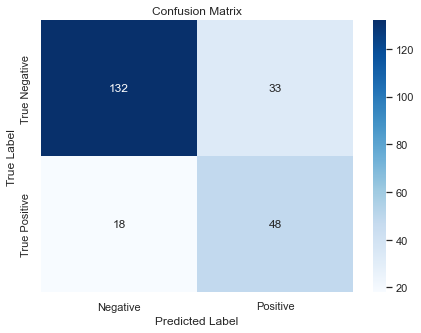

In [152]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_pred_tuned, y_test)

# Etiketler ve sınıflar
labels = ["Negative", "Positive"]
classes = ["True " + label for label in labels]

# Confusion matrix görseli
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()